## 1. Importing data and dropping line 4877 because wrong
 

In [1]:
import json
import pandas as pd
import os

# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')
train_data = []

# Read the file line by line
print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            # json.loads() parses one line (one JSON object) into a Python dictionary
            train_data.append(json.loads(line))

    print(f"Successfully loaded {len(train_data)} battles.")
except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")



# Drop the batte 4877 (WRONG)
train_data = [battle for battle in train_data if battle.get("battle_id") != 4877]

Loading data from '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.


## 2. Implementing functions to create features

In [2]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import json

BASE_KEYS = ['base_hp', 'base_atk', 'base_def', 'base_spa', 'base_spd', 'base_spe']

def build_species_index(*datasets):
    
    idx = {}

    def take(p):
        name = str(p.get('name', '')).lower()
        if not name: return
        rec = {k: int(p.get(k, 0)) for k in BASE_KEYS}
        if name not in idx or sum(idx[name].values()) < sum(rec.values()):
            idx[name] = rec

    for data in datasets:
        for b in data:
            for p in b.get('p1_team_details', []):
                take(p)
            if b.get('p2_lead_details'):
                take(b['p2_lead_details'])
            for ev in b.get('battle_timeline', []):
                take(ev.get('p2_pokemon_state', {}))
    return idx


species_idx = build_species_index(train_data)


def get_lead_speed(battle: dict, player: str, species_idx: dict) -> int:

    lead_name = None

    if player == 'p1':
        lead_name = battle.get('p1_lead_details', {}).get('name')
    elif player == 'p2':
        lead_name = battle.get('p2_lead_details', {}).get('name')

    if not lead_name:
        timeline = battle.get('battle_timeline', [])
        if timeline:
            if player == 'p1':
                lead_name = timeline[0].get('p1_pokemon_state', {}).get('name')
            else:
                lead_name = timeline[0].get('p2_pokemon_state', {}).get('name')

    if not lead_name and player == 'p1':
        team_p1 = battle.get('p1_team_details', [])
        if team_p1:
            lead_name = team_p1[0].get('name')

    if not lead_name:
        return 0

    stats = species_idx.get(str(lead_name).lower())
    if not stats:
        return 0

    return int(stats.get('base_spe', 0))


def track_pokemon_conditions(battle: dict):
  
    p1_pok_cond = {
        pokemon.get('name', f'p1_unknown_{i}'): {
            'hp': 1.0,
            'status': 'nostatus'
        }
        for i, pokemon in enumerate(battle.get('p1_team_details', []))
    }

    p2_pok_cond = {}
    p2_lead_name = battle.get('p2_lead_details', {}).get('name')
    if p2_lead_name:
        p2_pok_cond[p2_lead_name] = {
            'hp': 1.0,
            'status': 'nostatus'
        }

    timeline = battle.get('battle_timeline', []) or []

    for turn in timeline:
        p1_state = turn.get('p1_pokemon_state', {}) or {}
        p2_state = turn.get('p2_pokemon_state', {}) or {}

        name_p1 = p1_state.get('name')
        if name_p1:
            p1_pok_cond[name_p1] = {
                'hp': p1_state.get('hp_pct', 1.0),
                'status': p1_state.get('status', 'nostatus')
            }

        name_p2 = p2_state.get('name')
        if name_p2:
            p2_pok_cond[name_p2] = {
                'hp': p2_state.get('hp_pct', 1.0),
                'status': p2_state.get('status', 'nostatus')
            }

    p1_n_changes = 0
    p2_n_changes = 0
    p1_prev_name = None
    p2_prev_name = None

    for turn in timeline:
        p1_curr = turn.get('p1_pokemon_state', {}) or {}
        p2_curr = turn.get('p2_pokemon_state', {}) or {}

        name_curr_p1 = p1_curr.get('name')
        name_curr_p2 = p2_curr.get('name')

        if p1_prev_name is not None and name_curr_p1 != p1_prev_name:
            p1_n_changes += 1
        if p2_prev_name is not None and name_curr_p2 != p2_prev_name:
            p2_n_changes += 1

        p1_prev_name = name_curr_p1
        p2_prev_name = name_curr_p2

    if timeline:
        last_turn = timeline[-1]
        last_p1 = last_turn.get('p1_pokemon_state', {}) or {}
        last_p2 = last_turn.get('p2_pokemon_state', {}) or {}

        p1_effects = len(last_p1.get('effects', [])) * 0.5
        p2_effects = len(last_p2.get('effects', [])) * 0.5
    else:
        p1_effects = 0.0
        p2_effects = 0.0

    while len(p2_pok_cond) < 6:
        idx = len(p2_pok_cond)
        p2_pok_cond[f'p2_unknown_{idx}'] = {
            'hp': 1.0,
            'status': 'nostatus'
        }

    return p1_n_changes, p1_effects, p1_pok_cond, p2_n_changes, p2_effects, p2_pok_cond


def compute_differences_base_stats(p1_pok_cond: dict,
                                   p2_pok_cond: dict,
                                   species_idx: dict):
 
    p1_total_speed = p2_total_speed = 0
    p1_total_attack = p2_total_attack = 0
    p1_total_defense = p2_total_defense = 0
    p1_total_sp_attack = p2_total_sp_attack = 0
    p1_total_sp_defense = p2_total_sp_defense = 0
    p1_total_hp = p2_total_hp = 0

    for name in p1_pok_cond.keys():
        key = str(name).lower()
        if key in species_idx:
            p1_total_speed   += species_idx[key]['base_spe']
            p1_total_attack  += species_idx[key]['base_atk']
            p1_total_defense += species_idx[key]['base_def']
            p1_total_sp_attack   += species_idx[key]['base_spa']
            p1_total_sp_defense  += species_idx[key]['base_spd']
            p1_total_hp      += species_idx[key]['base_hp']

    for name in p2_pok_cond.keys():
        key = str(name).lower()
        if key in species_idx:
            p2_total_speed   += species_idx[key]['base_spe']
            p2_total_attack  += species_idx[key]['base_atk']
            p2_total_defense += species_idx[key]['base_def']
            p2_total_sp_attack   += species_idx[key]['base_spa']
            p2_total_sp_defense  += species_idx[key]['base_spd']
            p2_total_hp      += species_idx[key]['base_hp']

    speed      = p1_total_speed   - p2_total_speed
    defense    = p1_total_defense - p2_total_defense
    attack     = p1_total_attack  - p2_total_attack
    sp_attack  = p1_total_sp_attack  - p2_total_sp_attack
    sp_defense = p1_total_sp_defense - p2_total_sp_defense
    hp         = p1_total_hp      - p2_total_hp

    return speed, defense, attack, sp_attack, sp_defense, hp

def extract_boost_difference(timeline: list[dict]):

    boost_keys = ['atk', 'def', 'spa', 'spd', 'spe']

    prev_boosts_p1 = {}  
    prev_boosts_p2 = {}

    p1_total = 0
    p2_total = 0

    for ev in timeline:

        p1_state = ev.get("p1_pokemon_state", {}) or {}
        name_p1 = p1_state.get("name")

        if name_p1:
            curr_boosts_p1 = {
                k: p1_state.get("boosts", {}).get(k, 0)
                for k in boost_keys
            }

            prev_for_p1 = prev_boosts_p1.get(
                name_p1,
                {k: 0 for k in boost_keys}
            )

            for k in boost_keys:
                delta = curr_boosts_p1[k] - prev_for_p1[k]
                if delta > 0:
                    p1_total += delta

            prev_boosts_p1[name_p1] = curr_boosts_p1

        p2_state = ev.get("p2_pokemon_state", {}) or {}
        name_p2 = p2_state.get("name")

        if name_p2:
            curr_boosts_p2 = {
                k: p2_state.get("boosts", {}).get(k, 0)
                for k in boost_keys
            }

            prev_for_p2 = prev_boosts_p2.get(
                name_p2,
                {k: 0 for k in boost_keys}
            )

            for k in boost_keys:
                delta = curr_boosts_p2[k] - prev_for_p2[k]
                if delta > 0:
                    p2_total += delta

            prev_boosts_p2[name_p2] = curr_boosts_p2

    return p1_total, p2_total, p1_total - p2_total

def extract_accuracy_difference(timeline: list[dict]):
    
    p1_acc_values = []
    p2_acc_values = []

    for ev in timeline:
       
        p1_move = ev.get("p1_move_details") or {}
        if "accuracy" in p1_move:
            acc = p1_move.get("accuracy", None)
            if isinstance(acc, (int, float)):
                p1_acc_values.append(acc)

        p2_move = ev.get("p2_move_details") or {}
        if "accuracy" in p2_move:
            acc = p2_move.get("accuracy", None)
            if isinstance(acc, (int, float)):
                p2_acc_values.append(acc)

    p1_mean = np.mean(p1_acc_values) if p1_acc_values else 0.0
    p2_mean = np.mean(p2_acc_values) if p2_acc_values else 0.0

    return p1_mean, p2_mean, p1_mean - p2_mean

    

With the build_species_index function, we created a dictionary containing the Pokémon names and their BASE_KEYS for all species that appear in the battle timeline (only using train_set pokémon).
With the get_lead_speed function, we retrieve the base Speed (base_spe) of the player’s lead Pokémon by checking lead details first, then the first timeline entry, and finally fallback options if needed.
The track_pokemon_conditions function processes the battle timeline to rebuild each player’s final Pokémon conditions, count only voluntary switches (excluding those forced by a KO), and compute last-turn effects weighted by 0.5, since we decided to treat effects as having half the impact of status conditions. It also fills P2’s unseen Pokémon slots up to six.
The compute_differences_base_stats function sums all base stats of the Pokémon appearing for each player (using the species index) and returns the differences (P1 − P2) for Speed, Defense, Attack, Special Attack, Special Defense, and HP.
The extract_boost_difference function scans the battle timeline and tracks boost changes for every Pokémon. It counts only positive increases in atk, def, spa, spd, and spe stages, ignoring reductions or resets. It returns the total boosts gained by P1, by P2, and their difference (P1 − P2). Lastly the extract_accuracy_difference function traverses the battle timeline, gathers the accuracy values of all recorded moves for P1 and P2, computes each player’s average accuracy, and returns P1’s mean accuracy, P2’s mean accuracy, and their difference (P1 − P2).

## 3. Creating Feature df

In [3]:
def create_features(data: list[dict]) -> pd.DataFrame:

    feature_list = []

    for battle in tqdm(data, desc="Extracting features"):
        feats = {}

        timeline = battle.get('battle_timeline', []) or []

        # accuracy diff
        p1_acc, p2_acc, acc_diff = extract_accuracy_difference(timeline)
        feats['accuracy_diff'] = acc_diff

        (p1_n_changes,
         p1_effects,
         p1_pok_cond,
         p2_n_changes,
         p2_effects,
         p2_pok_cond) = track_pokemon_conditions(battle)

        # boost diff
        p1_boosts, p2_boosts, boost_diff = extract_boost_difference(timeline)
        feats['boost_diff'] = boost_diff

        # mean HP
        p1_mean_pc_hp = np.mean([info['hp'] for info in p1_pok_cond.values()])
        p2_mean_pc_hp = np.mean([info['hp'] for info in p2_pok_cond.values()])
        feats['p1_mean_pc_hp'] = p1_mean_pc_hp
        feats['p2_mean_pc_hp'] = p2_mean_pc_hp

        # surviving pokémon
        feats['p1_surviving_pokemon'] = sum(info['hp'] > 0 for info in p1_pok_cond.values())
        feats['p2_surviving_pokemon'] = sum(info['hp'] > 0 for info in p2_pok_cond.values())

        #  status score 
        p1_status_score = sum(
            1 for info in p1_pok_cond.values()
            if info['hp'] > 0 and info['status'] != 'nostatus'
        ) + p1_effects

        p2_status_score = sum(
            1 for info in p2_pok_cond.values()
            if info['hp'] > 0 and info['status'] != 'nostatus'
        ) + p2_effects

        feats['p1_status_score'] = p1_status_score
        feats['p2_status_score'] = p2_status_score

        # base stats difference (P1-P2)
        speed, defense, attack, sp_attack, sp_defense, hp = compute_differences_base_stats(
            p1_pok_cond, p2_pok_cond, species_idx
        )
        feats['total_speed_difference']      = speed
        feats['total_attack_difference']     = attack
        feats['total_defense_difference']    = defense
        feats['total_sp_attack_difference']  = sp_attack
        feats['total_sp_defense_difference'] = sp_defense
        feats['total_hp_difference']         = hp

        # switch diff
        feats['switch_diff'] = p1_n_changes - p2_n_changes

        # lead speed diff
        p1_lead_speed = get_lead_speed(battle, 'p1', species_idx)
        p2_lead_speed = get_lead_speed(battle, 'p2', species_idx)
        feats['lead_speed_diff'] = p1_lead_speed - p2_lead_speed

        
        feats['battle_id'] = battle.get('battle_id')
        if 'player_won' in battle:
            feats['player_won'] = int(battle['player_won'])

        feature_list.append(feats)

    return pd.DataFrame(feature_list).fillna(0)



print("Processing training data...")
train_df = create_features(train_data)

print("\nProcessing test data...")
test_data = []
with open(test_file_path, 'r') as f:
    for line in f:
        test_data.append(json.loads(line))
test_df = create_features(test_data)

print("\nTraining features preview:")
display(train_df.head())




Processing training data...


Extracting features:   0%|          | 0/9999 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]


Training features preview:


,accuracy_diff,boost_diff,p1_mean_pc_hp,p2_mean_pc_hp,p1_surviving_pokemon,p2_surviving_pokemon,p1_status_score,p2_status_score,total_speed_difference,total_attack_difference,total_defense_difference,total_sp_attack_difference,total_sp_defense_difference,total_hp_difference,switch_diff,lead_speed_diff,battle_id,player_won
0,-0.061574,-4,0.645469,0.441250,5,5,2.5,3.5,230,150,140,205,205,130,-4,0,0,1
1,-0.006522,0,0.263333,0.428333,3,6,0.5,3.5,-110,0,15,-60,-60,45,0,-25,1,1
2,0.001263,4,0.696667,0.693333,5,6,1.5,3.5,5,285,225,100,100,305,2,5,2,1
3,0.014348,0,0.340000,0.476667,3,6,0.5,1.5,145,60,85,260,260,325,1,0,3,1
4,0.019231,2,0.626667,0.525000,5,6,2.5,4.5,75,70,140,120,120,45,-2,5,4,1


The create_features function processes each battle and computes a full set of engineered features: average HP, surviving Pokémon count, status scores, base-stat differences, switch difference, lead-speed difference, boost difference, and accuracy difference. All extracted values are assembled into a structured DataFrame for model training and evaluation. We also print the first 5 rows of train_df to inspect the features. First looking at dataframe we saw some equal features (for the first 5 lines) so we decided to look at correlation heatmap.

## 4. Features check

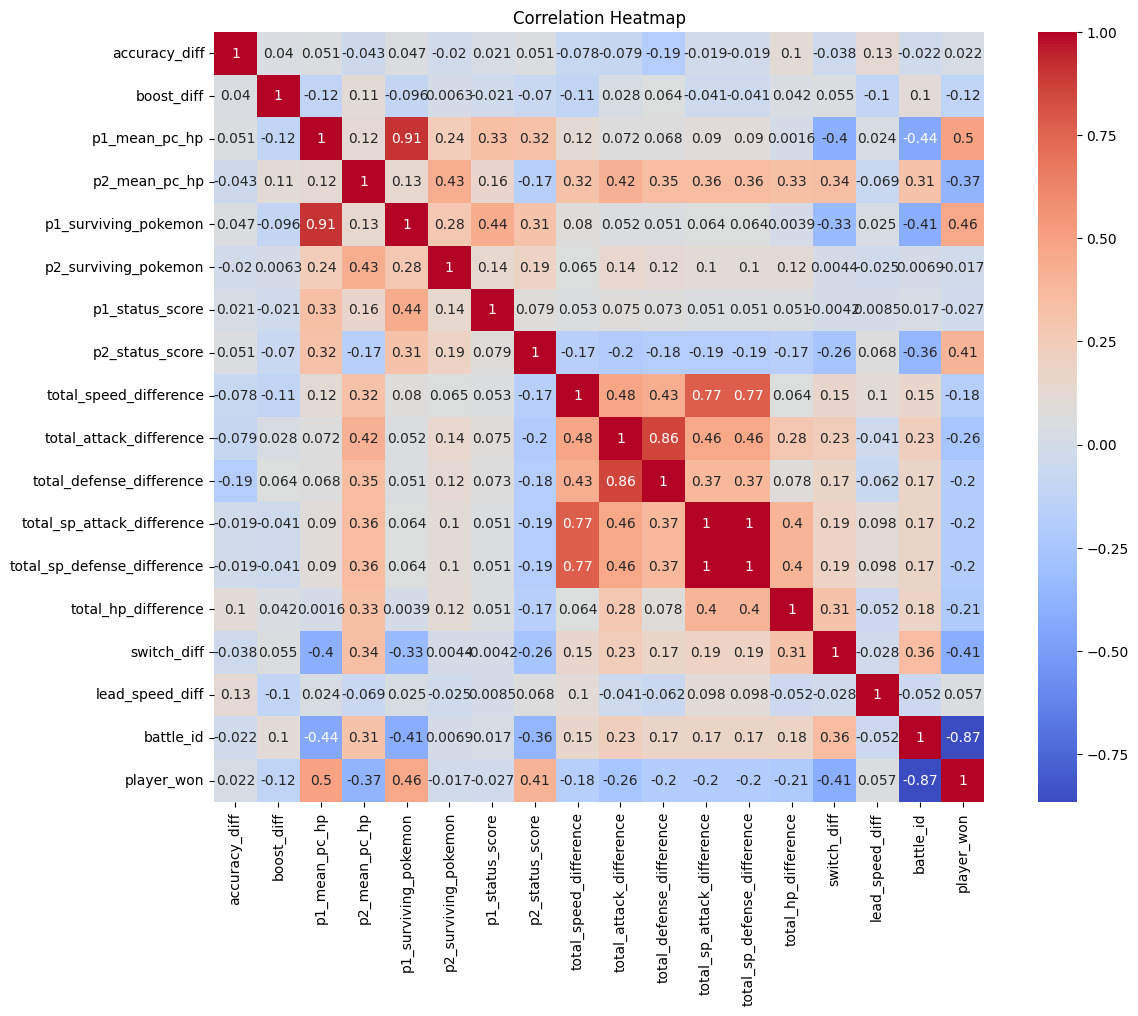

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = train_df.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", annot=True, square=True)
plt.title("Correlation Heatmap")
plt.show()


As we saw before, the two features ‘total_sp_attack_difference’ and ‘total_sp_defense_difference’ are perfectly correlated, so we decided to drop one of them (‘total_sp_defense_difference’).

In [5]:
cols_to_drop = ['total_sp_defense_difference']

train_df = train_df.drop(columns=cols_to_drop, errors='ignore')
test_df  = test_df.drop(columns=cols_to_drop, errors='ignore')

feature_names = [c for c in train_df.columns if c not in ['battle_id', 'player_won']]
X_train = train_df[feature_names]
y_train = train_df['player_won']

X_test = test_df[feature_names]

In [6]:
display(X_train.head())

,accuracy_diff,boost_diff,p1_mean_pc_hp,p2_mean_pc_hp,p1_surviving_pokemon,p2_surviving_pokemon,p1_status_score,p2_status_score,total_speed_difference,total_attack_difference,total_defense_difference,total_sp_attack_difference,total_hp_difference,switch_diff,lead_speed_diff
0,-0.061574,-4,0.645469,0.441250,5,5,2.5,3.5,230,150,140,205,130,-4,0
1,-0.006522,0,0.263333,0.428333,3,6,0.5,3.5,-110,0,15,-60,45,0,-25
2,0.001263,4,0.696667,0.693333,5,6,1.5,3.5,5,285,225,100,305,2,5
3,0.014348,0,0.340000,0.476667,3,6,0.5,1.5,145,60,85,260,325,1,0
4,0.019231,2,0.626667,0.525000,5,6,2.5,4.5,75,70,140,120,45,-2,5


## 5. Implementig the model

For this notebook we decided to use a stacking model.
The base learners are SVM, Logistic Regression, KNN, Random Forest, and XGBoost, each tuned with a light Grid Search.
For the meta-model we chose a Logistic Regression classifier.

In [7]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=1000,
        solver='liblinear', 
        random_state=42
    ))
])

param_lr = {
    'logreg__C': [0.1, 1.0, 10.0],
    'logreg__penalty': ['l1', 'l2']
}


knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_knn = {
    'knn__n_neighbors': [5, 11, 21],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]   
}


svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

param_svm = {
    'svm__C': [0.5, 1.0, 5.0],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['scale', 'auto']
}

rf = RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

param_rf = {
    'n_estimators': [200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}


xgb = XGBClassifier(
    tree_method='hist',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

param_xgb = {
    'n_estimators': [200, 400],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}



def tune_model(estimator, param_grid, X, y, cv, scoring='accuracy', name='model'):
    print(f"\nTuning {name}...")
    gs = GridSearchCV(
        estimator,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X, y)
    print(f"Best params for {name}: {gs.best_params_}")
    print(f"Best {scoring} for {name}: {gs.best_score_:.4f}")
    return gs.best_estimator_

best_lr  = tune_model(lr_pipe,  param_lr,  X_train, y_train, cv, name='Logistic Regression')
best_knn = tune_model(knn_pipe, param_knn, X_train, y_train, cv, name='KNN')
best_svm = tune_model(svm_pipe, param_svm, X_train, y_train, cv, name='SVM')
best_rf  = tune_model(rf,       param_rf,  X_train, y_train, cv, name='Random Forest')
best_xgb = tune_model(xgb,      param_xgb, X_train, y_train, cv, name='XGBoost')


base_estimators = [
    ('lr',  best_lr),
    ('knn', best_knn),
    ('svm', best_svm),
    ('rf',  best_rf),
    ('xgb', best_xgb)
]


final_estimator = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    random_state=42
)

stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=cv,
    n_jobs=-1,
    passthrough=False  
)

print("\nFitting stacking classifier...")
stack_clf.fit(X_train, y_train)


y_test_proba = stack_clf.predict_proba(X_test)[:, 1]

y_test_pred = stack_clf.predict(X_test)


print("\nValutazione meta-modello (Stacking) con CV=5...")

stack_scores = cross_val_score(
    stack_clf,
    X_train,
    y_train,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print(f"Accuracy media Stacking (CV=5): {stack_scores.mean():.4f}")
print(f"Deviazione standard:             {stack_scores.std():.4f}")


Tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for Logistic Regression: {'logreg__C': 10.0, 'logreg__penalty': 'l1'}
Best accuracy for Logistic Regression: 0.8497

Tuning KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for KNN: {'knn__n_neighbors': 21, 'knn__p': 1, 'knn__weights': 'distance'}
Best accuracy for KNN: 0.8317

Tuning SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for SVM: {'svm__C': 0.5, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best accuracy for SVM: 0.8456

Tuning Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best accuracy for Random Forest: 0.8398

Tuning XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.

## Creating Submission file

In [8]:

submission = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("Salvata: submission.csv")

Salvata: submission.csv
